## **12. Time Series**

In [3]:
# 일변량 시계열 데이터 불러오기
# 출처: 보건복지부_코로나19 시도 발생현황, 공공데이터포털
from pandas import read_csv
ts = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv', encoding='utf-8').filter(['날짜', '전일대비증감수'])
ts['날짜'] = ts['날짜'].astype('datetime64[ns]') #날짜 데이터로 설정
ts = ts.set_index('날짜') #인덱스를 날짜로 셋팅
ts_head = ts.head(334) # 2021년 1~11월 데이터
ts_tail = ts.tail(31) # 2021년 12월 데이터
print(ts_head)

            전일대비증감수
날짜                 
2021-01-01      357
2021-01-02      250
2021-01-03      198
2021-01-04      329
2021-01-05      199
...             ...
2021-11-26     1742
2021-11-27     1888
2021-11-28     1676
2021-11-29     1393
2021-11-30     1186

[334 rows x 1 columns]


### **12-1. 시계열 탐색적 분석**

#### 12-1-1. 일반적 EDA

C:\Users\sunwa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sunwa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sunwa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sunwa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sunwa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes

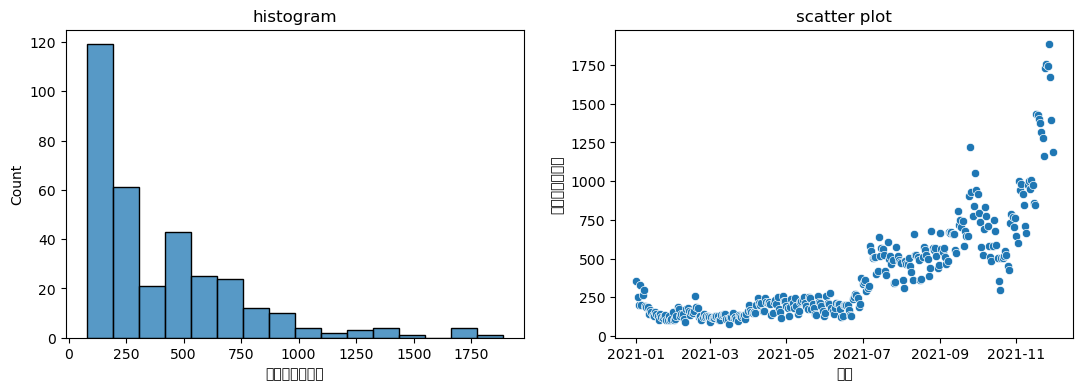


 [요약통계량]
         count        mean         std   min    25%    50%    75%     max
전일대비증감수  334.0  405.152695  336.013188  79.0  152.0  252.5  556.0  1888.0


In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(13,4))

# 히스토그램 (보통, 변화에 관심이 많으므로 차분한 시계열로 EDA 진행)
axes[0].set_title("histogram")
sns.histplot(x='전일대비증감수', data=ts_head, ax=axes[0])

# 산점도
axes[1].set_title("scatter plot")
sns.scatterplot(x='날짜', y='전일대비증감수', data=ts_head, ax=axes[1])
plt.show()

# 요약 통계량
print("\n [요약통계량]")
print(ts_head.describe().T)

#### 12-1-2. 시계열 특화된 EDA

#### 정상성 확인
- Stationarity: 시간이 지나도 평균/분산 일정, 추세나/계절성 없음
- 검정방법
  1) ADF: H0 = 단위근이 있다, H0 기각시 정상 시계열
  2) KPSS: H0 = 정상 시계열이다, H0 기각하지 않으면 정상 시계열
  3) ACF 그래프: 시차 증가할수록 빠르게 0으로 감소 (비정상성: 느리게 감소)
- 정상화 방법
  1) 평균 변화: 차분
  2) 분산 변화: 변환 (로그, 제곱근, Box-cox, Yeo-Johnson 등)

In [7]:
# 정상성 검정1 - ADF
# H0: 단위근을 포함한다 (비정상)
# H1: 단위근을 포함하지 않는다 (정상)
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts_head, regression='c', autolag='AIC')
# c: 상수항만 (기본값), ct: c + 선형 추세, ctt: ct + 이차 추세
print("ADF Statistics: {:.3f}, p-value: {:.3f}".format(result[0], result[1]))
## 비정상 시계열이라는 결론

ADF Statistics: 0.762, p-value: 0.991


In [8]:
# 정상성 검정2 - KPSS
# H0: 정상시계열과 차이가 없다 (정상), # H1: 정상시계열과 차이가 있다 (비정상)
from statsmodels.tsa.stattools import kpss
result = kpss(ts_head, regression='c', nlags='auto')
print("KPSS Statistics: {:.3f}, p-value: {:.3f}".format(result[0], result[1]))
## 비정상 시계열이라는 결론

KPSS Statistics: 2.210, p-value: 0.010


C:\Users\sunwa\AppData\Local\Temp\ipykernel_15284\2916895280.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(ts_head, regression='c', nlags='auto')


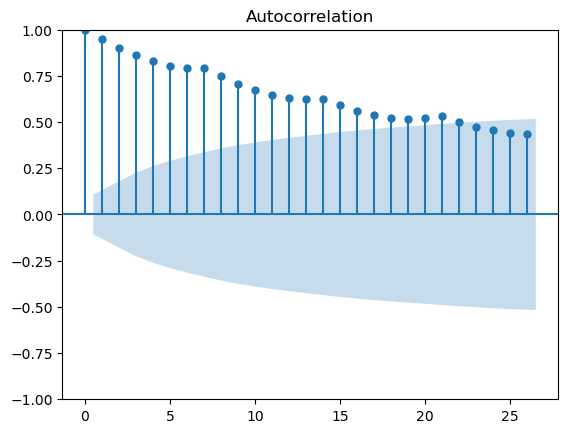

In [9]:
# 정상성 검정3 - ACF 그래프
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts_head)
plt.show() ## 시차에 따라 값이 빠르게 떨어지지 않기 때문에 비정상 시계열이라는 결론

#### 자기상관 확인
- autocorrelation: 서로 다른 시점 데이터 간의 선형적 상관관계
- 검정방법
  1) ACF/PACF: y값이 임계영역에서 벗어나면 자기상관성 존재
  2) Ljung-box: H0 = 자기상관이 없다, H0 채택하면 자기상관성 없음
  3) Durbin-watson (회귀 잔차분석): 2 - 자기상관 없음, 0 - 양, 4 - 음

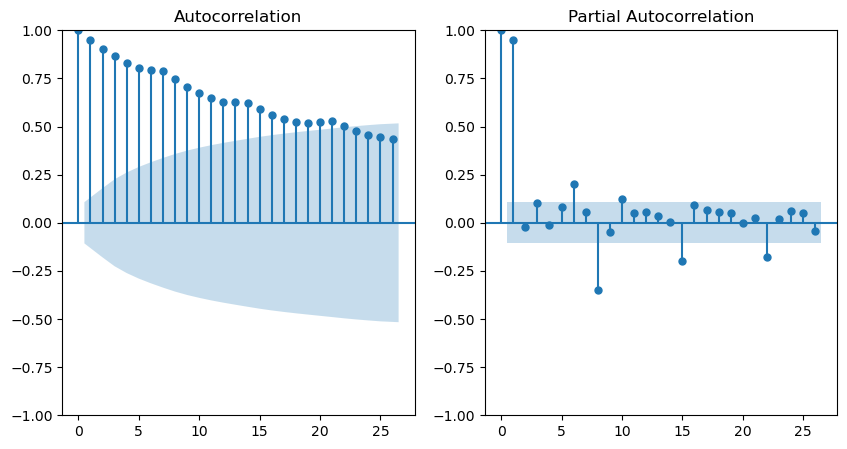

0시차: 자기상관계수 1.000, 신뢰구간 1.000~1.000
1시차: 자기상관계수 0.954, 신뢰구간 0.846~1.061
2시차: 자기상관계수 0.907, 신뢰구간 0.727~1.087
3시차: 자기상관계수 0.873, 신뢰구간 0.646~1.100


In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

# 자기상관 검정1 - ACF/PACF 그래프
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2, figsize=(10,5))
plot_acf(ts_head, ax=ax[0])
plot_pacf(ts_head, ax=ax[1])
plt.show()
## ACF 그래프의 임계영역을 벗어나는 값들을 볼 때, 자기 상관이 있음을 알 수 있다.
## PACF 그래프의 임계영역을 벗어나는 시차 1, 3, 6, 8 등이 자기 상관이 있음을 알 수 있다.

# 시차별 자기상관계수와 자기상관계수가 0이라는 95% 신뢰구간(아래 음영)도 구할 수 있다.
ACs, confs = acf(ts_head, fft=False, nlags = 3, alpha=0.05, adjusted=True)
for lag, ac, conf in zip(range(3+1), ACs, confs):
    print(f"{lag}시차: 자기상관계수 {ac:.3f}, 신뢰구간 {conf[0]:.3f}~{conf[1]:.3f}")

In [11]:
# 자기상관 검정2 - Ljung-box test
# H0: 데이터가 일련의 상관관계를 나타내지 않는다.
# H1: 데이터가 일련의 상관관계를 나타낸다.
from statsmodels.stats.diagnostic import acorr_ljungbox
print("융박스 테스트:")
result = acorr_ljungbox(ts_head, return_df=True, auto_lag=True).head(3)
print(result) ## ts_head가 자기상관이 있다는 결론을 얻었다.

융박스 테스트:
      lb_stat      lb_pvalue
1  304.691106   3.131578e-68
2  579.605498  1.381228e-126
3  833.394832  2.474556e-180


In [12]:
# 자기상관 검정3 - Durbin-watson test
# 통계량이 2에 가까우면 자기 상관이 없다. 
# 통계량이 0 혹은 4에 가까우면 자기 상관이 있다.
from statsmodels.stats.stattools import durbin_watson
result = durbin_watson(ts_head)
print(result) ## ts_head가 자기상관이 있다는 결론을 얻었다.

[0.03337102]


#### 시계열 분해
- Decomposition: 추세, 계절성, 순환, 불규칙 변동으로 분해하여 데이터 파악 및 예측
1) 이동평균법: 계절/불규칙 변동 제거, 주요 파라미터 (window, min_periods)
2) 지수평활법: 불규칙 변동 제거, 주요 파라미터 (alpha = 지수평활계수)
3) STL 분해: 계절/추세/잔차로 분해 가능

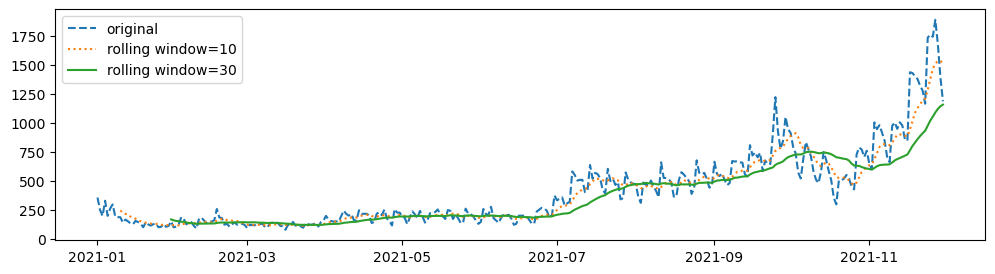

In [13]:
# 이동평균법: 계절 변동과 불규칙 변동 제거
fig, ax = plt.subplots(1,1, figsize=(12,3))

titles = ['original', 'rolling window=10', 'rolling window=30']
rw10 = ts_head.rolling(window=10).mean().dropna()
rw30 = ts_head.rolling(window=30).mean().dropna()
data_list = [ts_head, rw10, rw30]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label=title, linestyle=ls)
plt.legend()
plt.show()

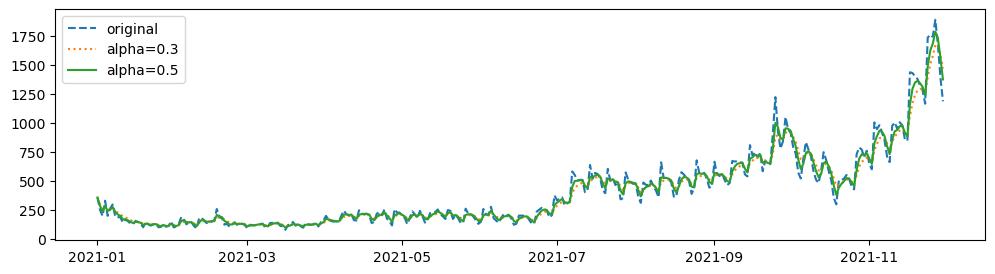

In [17]:
# 지수평활법: 불규칙변동 제거
fig, ax = plt.subplots(1,1, figsize=(12,3))

titles = ['original', 'alpha=0.3', 'alpha=0.5']
ewm03 = ts_head.ewm(alpha=0.3).mean()
ewm05 = ts_head.ewm(alpha=0.5).mean()
data_list = [ts_head, ewm03, ewm05]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label=title, linestyle=ls)
plt.legend()
plt.show()

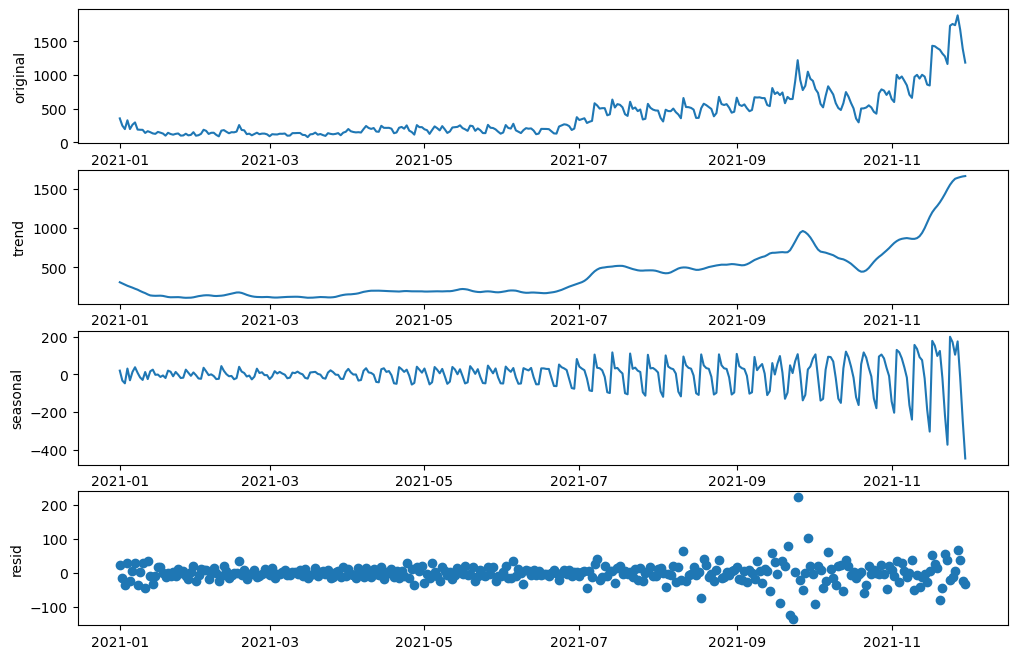

In [18]:
# STL 분해
from statsmodels.tsa.seasonal import STL
# seasonal = Length of the seasonal smoother
# trend = Length of the trend smoother
fitted = STL(ts_head, seasonal=7, trend=9).fit()
resid = fitted.resid # 잔차
seasonal = fitted.seasonal # 추정된 계절 요소
trend = fitted.trend # 추정된 트렌드 요소

titles = ['original', 'trend', 'seasonal', 'resid' ]
data_list = [ts_head, trend, seasonal, resid]
fig, axes = plt.subplots(4,1, figsize=(12,8))
for title, data, ax in zip(titles, data_list, axes):
    ax.set_ylabel(title)
    if title != 'resid':
        ax.plot(data)
    else:
        ax.scatter(x=data.index, y=data.values)
plt.show()
## plotting은 fitted.plot()로 한번에 할 수도 있다.

#### 12-2. 시계열 데이터 전처리

#### 시계열 데이터 다루기

In [21]:
import datetime as dt
import pandas as pd
import time
from pandas import read_csv
ts = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv', encoding='utf-8')

# 날짜 데이터로 타입 변경하기 - (1) object - datetime
print("object: ", ts['날짜'].dtypes)
ts['날짜'] = ts['날짜'].astype('datetime64[ns]')
# pandas는 날짜/시간 데이터 형식으로 datetime64[ns] (나노초 단위)만 지원 
print("object to datetime: ", ts['날짜'].dtypes)

object:  object
object to datetime:  datetime64[ns]


In [20]:
# 날짜 데이터로 타입 변경하기 - (2) string - datetime
string = "2018-09-13 22:39:04"
print("string: ", type(string))
# string에서 나타내는 년월일 정보와 대응하도록 format을 적어줘야 해당 날짜로 인식 가능
datetime = dt.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')
print("string to datetime: ", type(datetime))
string2 = datetime.strftime('%Y-%m-%d %H:%M:%S') 
print("datetime to string: ", type(string2))

string:  <class 'str'>
string to datetime:  <class 'datetime.datetime'>
datetime to string:  <class 'str'>


In [28]:
# 날짜 데이터로 타입 변경하기 - (3) timestamp - datetime
timestamp = 2551780740 #timestamp
datetime = dt.datetime.fromtimestamp(timestamp) # 로컬 기준
# utcdatetime = dt.datetime.utcfromtimestamp(timestamp) # UTC 기준 --> 없어질 코드

from datetime import timezone
utcdatetime = datetime.fromtimestamp(timestamp, timezone.utc)

timestamp2 = time.mktime(datetime.timetuple())
print(f"timestamp to local datetime (utc datetime): {datetime} ({utcdatetime})")
print("datetime to timestamp: ", timestamp2)

timestamp to local datetime (utc datetime): 2050-11-11 20:59:00 (2050-11-11 11:59:00+00:00)
datetime to timestamp:  2551780740.0


In [29]:
# 날짜 데이터 생성하기 - (1) dt.datetime
date1 = dt.datetime(2023, 3, 20, 16, 0, 0) 
#year, month, day, hour, minute, second, ...
date2 = dt.datetime.now()
date_only = dt.date(2019,1,1)
time_only = dt.time(10, 0, 5)
print("직접 지정해서 만든 날짜 데이터: ", date1)
print("현재 시간을 반환하는 날짜 데이터: ", date2)
print("date_only: ", date_only)
print('time_only: ', time_only)

직접 지정해서 만든 날짜 데이터:  2023-03-20 16:00:00
현재 시간을 반환하는 날짜 데이터:  2025-04-17 17:25:01.350584
date_only:  2019-01-01
time_only:  10:00:05


In [57]:
# 날짜 데이터 생성하기 - (2) pd.date_range, pd.period_range
## 시작날짜, 종료날짜, 날짜 개수(periods), 날짜의 간격 단위(freq)를 입력
## freq={'Y or YE(년)', 'M(월)', 'D(일)', 'min(분)' 'S(초)', 'Q(분기)', 'W(주)'}
date_list1 = pd.date_range('2016-01-01', periods=3, freq='YE-MAY')
date_list2 = pd.date_range('2016-01-01', periods=4, freq='W-MON')
date_list3 = pd.date_range('2016-01-01', '2016-01-02', freq='30min') #시간은 '60min'
print('일 단위 날짜들 3개:\n', date_list1, "\n")
print('주 단위 날짜들 4개:\n', date_list2, "\n")
print('시작-종료날짜 사이 30분 단위 날짜들:\n', date_list3[:2]) #앞의 2개만 print

일 단위 날짜들 3개:
 DatetimeIndex(['2016-05-31', '2017-05-31', '2018-05-31'], dtype='datetime64[ns]', freq='YE-MAY') 

주 단위 날짜들 4개:
 DatetimeIndex(['2016-01-04', '2016-01-11', '2016-01-18', '2016-01-25'], dtype='datetime64[ns]', freq='W-MON') 

시작-종료날짜 사이 30분 단위 날짜들:
 DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 00:30:00'], dtype='datetime64[ns]', freq='30min')


In [53]:
date_list4 = pd.period_range('2012-01-01', freq='Y', periods=2)
date_list5 = pd.period_range('2012-01-01', freq='Q', periods=3)
print('년 단위 날짜들 2개:\n', date_list4, "\n")
print('분기 단위 날짜들 3개:\n', date_list5)

년 단위 날짜들 2개:
 PeriodIndex(['2012', '2013'], dtype='period[Y-DEC]') 

분기 단위 날짜들 3개:
 PeriodIndex(['2012Q1', '2012Q2', '2012Q3'], dtype='period[Q-DEC]')


In [67]:
# 날짜 데이터의 형태, 값 변경하기
date3 = dt.datetime(2023, 3, 20, 0, 1, 10)
date3_c1 = date3.strftime("%Y-%m-%d") #네자리 년도, 월, 일
date3_c2 = date3.strftime("%y년 %m-%d %H:%M:%S") #두자리 년도, 월, 일, 시간, 분
print("형태 변경 전: ", date3)
print("형태 변경 후 1: ", date3_c1) 
print("형태 변경 후 2: ", date3_c2) 

형태 변경 전:  2023-03-20 00:01:10
형태 변경 후 1:  2023-03-20
형태 변경 후 2:  23년 03-20 00:01:10


In [64]:
date4 = date3.replace(year = 2022, minute=2)
# year, month, day, hour, minute, second, ...
print("값 변경 전: ", date3)
print("값 변경 후: ", date4)

값 변경 전:  2023-03-20 00:01:10
값 변경 후:  2022-03-20 00:02:10


In [68]:
date_only = dt.date(2019,1,1)
time_only = dt.time(10, 0, 5)
datetime = dt.datetime.combine(date_only, time_only)
print("값 병합 전: ", date_only, time_only)
print("값 병합 후: ", datetime)

값 병합 전:  2019-01-01 10:00:05
값 병합 후:  2019-01-01 10:00:05


In [69]:
# 날짜 데이터 간 연산하기
## weeks, days, hours, minutes, ...
weeks1 = dt.timedelta(weeks = 1)
today = dt.date(2023,2,10)
print("오늘: ", today)
print("오늘로부터 1주 전: ", today - weeks1)
print("오늘로부터 1주 후: ", today + weeks1)

오늘:  2023-02-10
오늘로부터 1주 전:  2023-02-03
오늘로부터 1주 후:  2023-02-17


In [70]:
# 년, 월, 일, 요일명, 요일인덱스 추출하기
print("\n 년, 월, 일, 요일명, 요일인덱스 추출하기: \n")
ts['날짜'] = ts['날짜'].astype('datetime64[ns]') #날짜의 데이터 타입 변경
ts['년'] = ts['날짜'].dt.year #날짜 feature에서 년 정보를 추출
ts['월'] = ts['날짜'].dt.month
ts['일'] = ts['날짜'].dt.day
ts['요일1'] = ts['날짜'].dt.weekday #0~6(월요일~일요일)
ts['요일2'] = ts['날짜'].dt.day_name() #영어 요일명
print(ts.filter(['날짜', '년', '월', '일', '요일1', '요일2']).head(5))


 년, 월, 일, 요일명, 요일인덱스 추출하기: 

          날짜     년  월  일  요일1       요일2
0 2021-01-01  2021  1  1    4    Friday
1 2021-01-02  2021  1  2    5  Saturday
2 2021-01-03  2021  1  3    6    Sunday
3 2021-01-04  2021  1  4    0    Monday
4 2021-01-05  2021  1  5    1   Tuesday


#### 시계열 빈도 변경 (업샘플링, 다운샘플링)

In [15]:
import datetime as dt
import pandas as pd
import time
from pandas import read_csv
ts = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv', encoding='utf-8')

ts['날짜'] = ts['날짜'].astype('datetime64[ns]')
ts = ts.set_index('날짜')
print(ts.head())

            누적확진자수  전일대비증감수
날짜                         
2021-01-01   19352      357
2021-01-02   19602      250
2021-01-03   19800      198
2021-01-04   20129      329
2021-01-05   20328      199


In [13]:
# rule = 'YE(년)', 'ME(월)', 'D(일)', 'min(분)' 'S(초)', 'QE(분기)', 'W(주)'
# aggregating = .asfreq(), .sum(), .mean()
print("[freq='Q', asfreq]") # 해당 기간의 대표 날짜의 데이터를 반환
print(ts.resample(rule='QE').asfreq())

[freq='Q', asfreq]
            누적확진자수  전일대비증감수
날짜                         
2021-03-31   32029      158
2021-06-30   49986      375
2021-09-30  100492      945
2021-12-31  225235     1670


In [14]:
print("[freq='Q', sum] ") # 해당 기간의 데이터 합을 반환
print(ts.resample(rule='QE').sum())

[freq='Q', sum] 
              누적확진자수  전일대비증감수
날짜                           
2021-03-31   2357075    13034
2021-06-30   3726692    17957
2021-09-30   6672971    50508
2021-12-31  13440595   124799


In [16]:
print("[freq='Q', mean] ") # 해당 기간의 데이터 평균을 반환
print(ts.resample(rule='QE').mean())

[freq='Q', mean] 
                   누적확진자수      전일대비증감수
날짜                                    
2021-03-31   26189.722222   144.822222
2021-06-30   40952.659341   197.329670
2021-09-30   72532.293478   549.000000
2021-12-31  146093.423913  1356.510870


#### 결측치 처리
1) Forward fill: 계산 안 복잡, 실시간 데이터 쉽게 적용
2) Backward fill: 사전관찰이므로 특수한 경우에만 사용
3) Moving average: 가중치 동일한 산술평균 vs. 지수가중이동평균
4) Interpolation: 선형, 2/3차 스플라인, 다항식 보간법 등

In [58]:
import datetime as dt
import pandas as pd
import time
from pandas import read_csv, DataFrame
ts = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv', encoding='utf-8').filter(['날짜', '전일대비증감수'])

ts['날짜'] = ts['날짜'].astype('datetime64[ns]')
ts = ts.set_index('날짜')
print("결측치 확인: ", ts.isna().sum())

결측치 확인:  전일대비증감수    0
dtype: int64


In [61]:
# 결측치 있는 데이터로 만들기
ts_na = ts.copy()
import numpy as np
random_numbers = np.random.randint(0,len(ts)-1, 50)
for num in random_numbers:
    ts_na.iloc[num, :] = np.nan
print("결측치 확인: ", ts_na.isna().sum())

결측치 확인:  전일대비증감수    48
dtype: int64


In [62]:
# 1. Forward fill (앞의 값으로 채우기)
ffill = ts_na.ffill()

# 2. Backward fill (뒤의 값으로 채우기)
bfill = ts_na.bfill()

# 3. Moving average (이동평균, 중심 3개 값 평균으로 채우기)
ma = ts_na.rolling(window=3, min_periods=1, center=True).mean()  # 결측치 포함, 앞뒤 1개 데이터로 이동평균
ma2 = ts_na.rolling(window=3, min_periods=1).mean() # 결측치 포함, 과거 2개 데이터로 이동평균
ma3 = ts_na.shift(1).rolling(window=3, min_periods=1).mean() # 결측치 미포함, 과거 3개 데이터로 이동평균
ma_filled = ts_na.fillna(ma3.round(0))

df = pd.concat([ffill, bfill, ma_filled], axis=1)
df.columns = ['ffill', 'bfill', 'ma_filled']

print(ts_na.iloc[random_numbers[0]-3:random_numbers[0]+4])
print(df.iloc[random_numbers[0]-3:random_numbers[0]+4])

            전일대비증감수
날짜                 
2021-11-28   1676.0
2021-11-29   1393.0
2021-11-30   1186.0
2021-12-01      NaN
2021-12-02      NaN
2021-12-03   2099.0
2021-12-04      NaN
             ffill   bfill  ma_filled
날짜                                   
2021-11-28  1676.0  1676.0     1676.0
2021-11-29  1393.0  1393.0     1393.0
2021-11-30  1186.0  1186.0     1186.0
2021-12-01  1186.0  2099.0     1418.0
2021-12-02  1186.0  2099.0     1290.0
2021-12-03  2099.0  2099.0     2099.0
2021-12-04  2099.0  2032.0     2099.0


C:\Users\sunwa\anaconda3\Lib\site-packages\pandas\core\missing.py:604: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  terp = interpolate.UnivariateSpline(x, y, k=order, **kwargs)


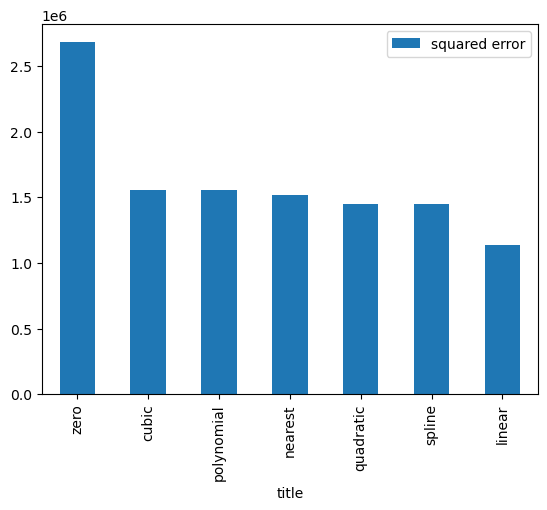

In [64]:
# 각종 보간 후, 실제 데이터와의 비교
linear = ts_na.interpolate(method='linear')
nearest = ts_na.interpolate(method='nearest')
zero = ts_na.interpolate(method='zero')
quadratic = ts_na.interpolate(method='quadratic') # polynomial order=2와 동일
cubic = ts_na.interpolate(method='cubic') # polynomial order=3과 동일
spline = ts_na.interpolate(method='spline', order=2)
polynomial = ts_na.interpolate(method='polynomial', order=3)

titles = ['linear', 'nearest', 'zero', 'quadratic', 'cubic', 'spline', 'polynomial']
data_list = [linear, nearest, zero, quadratic, cubic, spline, polynomial]
sqrd_error = []
for title, data in zip(titles, data_list):
    sqrd_e = sum((ts - data)['전일대비증감수']**2)
    sqrd_error.append(int(sqrd_e))
result = DataFrame({'title':titles, 'error': sqrd_error}).sort_values(by='error', ascending=False)

# 보간법 별 에러 비교
import matplotlib.pyplot as plt
result.plot.bar(x='title', y='error', label="squared error")
plt.show()

#### 차분과 변환

In [65]:
# 데이터 불러오기
ts = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv', encoding='utf-8').filter(['날짜', '전일대비증감수'])
ts['날짜'] = ts['날짜'].astype('datetime64[ns]') #날짜 데이터로 설정
ts = ts.set_index('날짜') #인덱스를 날짜로 셋팅
ts_head = ts.head(334) # 2021년 1~11월 데이터
ts_tail = ts.tail(31) # 2022년 12월 데이터

original: ADF p-value 0.991, KPSS p-value 0.010
diff(1): ADF p-value 0.004, KPSS p-value 0.100
diff(2): ADF p-value 0.005, KPSS p-value 0.100


C:\Users\sunwa\AppData\Local\Temp\ipykernel_7796\771584772.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kp = kpss(data)[1]
C:\Users\sunwa\AppData\Local\Temp\ipykernel_7796\771584772.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]
C:\Users\sunwa\AppData\Local\Temp\ipykernel_7796\771584772.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]


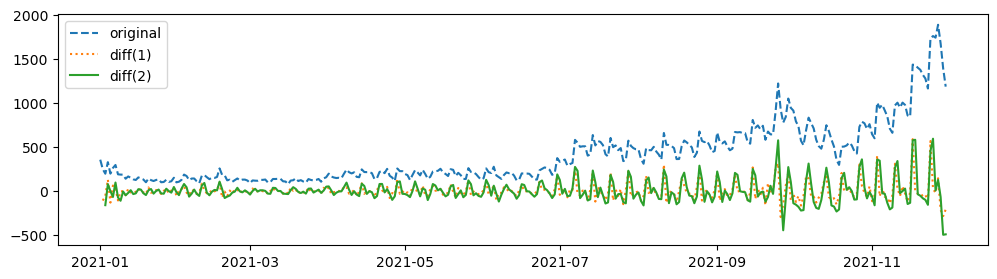

In [68]:
# 차분 전후 비교
from statsmodels.tsa.stattools import adfuller, kpss
fig, ax = plt.subplots(1,1, figsize=(12,3))

titles = ['original', 'diff(1)', 'diff(2)']
diff1 = ts_head.diff(periods=1).dropna()
diff2 = ts_head.diff(periods=2).dropna() # 2차 차분 아니고, 2시점 전과의 차이
diff2_true = ts.diff(1).diff(1) # 진정한 2차 차분

data_list = [ts_head, diff1, diff2]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label=title, linestyle=ls)
    ap = adfuller(data)[1]
    kp = kpss(data)[1]
    print("{}: ADF p-value {:.3f}, KPSS p-value {:.3f}".format(title, ap, kp))
plt.legend()
plt.show()
## 1번의 차분으로 정상시계열이 되었다.

original: ADF p-value 0.991, KPSS p-value 0.010
log: ADF p-value 0.001, KPSS p-value 0.100
box-cox: ADF p-value 0.000, KPSS p-value 0.100


C:\Users\sunwa\AppData\Local\Temp\ipykernel_7796\3898210135.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kp = kpss(data)[1]
C:\Users\sunwa\AppData\Local\Temp\ipykernel_7796\3898210135.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]
C:\Users\sunwa\AppData\Local\Temp\ipykernel_7796\3898210135.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]


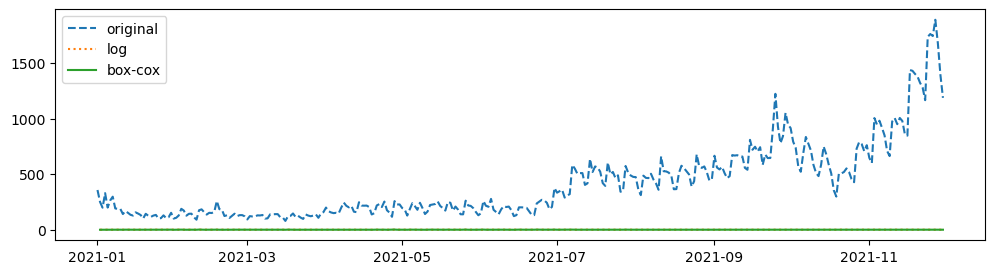

In [67]:
# 변환과 차분 전후 비교
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import PowerTransformer
import numpy as np
# 로그변환
log = np.log(ts_head)
# 박스콕스 변환
pt = PowerTransformer(method='box-cox')
rescaled = pt.fit_transform(ts_head)
boxcox = DataFrame(rescaled, index=ts_head.index, columns=ts_head.columns)
# 차분 1회
log = log.diff(1).dropna()
boxcox = boxcox.diff(1).dropna()

# 시각화
titles = ['original', 'log', 'box-cox']
data_list = [ts_head, log, boxcox]
ls_list = ['dashed', 'dotted', 'solid']
fig, ax = plt.subplots(1,1, figsize=(12,3))
for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label=title, linestyle=ls)
    ap = adfuller(data)[1]
    kp = kpss(data)[1]
    print("{}: ADF p-value {:.3f}, KPSS p-value {:.3f}".format(title, ap, kp))
plt.legend()
plt.show()

#### 12-3. 시계열 모델링 및 평가
- SARIMA (Seasonal ARIMA): ARIMA(p,d,q) + (P,D,Q)m (m: 계절 주기당 시간 단계 수)
- **ARIMA 모형 적합 순서**
  1) 정상성 및 계절성 확인
  2) 정상성 작업: 차분 및 변환
  3) p/q 찾기: p는 PACF 절단점, q는 ACF 절단점
  4) 모델 검증: 잔차의 자기상관성과 정상성 판단

#### 박스-젠킨스(Box-Jenkins) 방법과 ARIMA

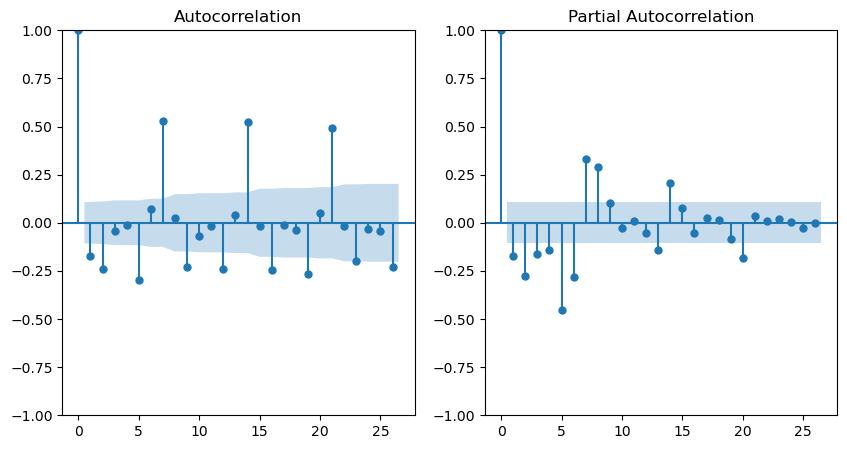

In [69]:
# 박스-젠킨스 방법
## boxcox 변환 및 차분을 통해 정상화한 시계열 데이터 'boxcox'로 적절한 차수를 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2, figsize=(10,5))
plot_acf(boxcox, ax=ax[0])
plot_pacf(boxcox, ax=ax[1])
plt.show()
## 차수는 plot 상의 절단점을 참고하여 p=9, q=2로 정하고 모델을 적합하기로 한다. 계절성이 있는 것으로 보인다.

# 모델의 비계절성 부분
p = 9 #AR 차수
d = 1 #차분 횟수
q = 2 #MA 차수

# 모델의 계절성 부분 (계절성이 없으면 생략 가능)
P = 0
D = 0
Q = 1 #ACF lag7에서 뾰족한 막대를 가지고, PACF는 지수적으로 감소
s = 7 #ACF lag7에서 뾰족한 막대를 가짐, 계절성 단위 (seasonal period)

In [70]:
## 모델 예측 및 잔차 분석
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# ARIMA에서 seasonal_order를 입력하면 SARIMAX와 동일한 결과를 얻음
model = ARIMA(ts_head, order=(p, d, q), seasonal_order=(P, D, Q, s)) #원본 데이터 입력
fitted = model.fit()
resid = fitted.resid

# pred1과 pred2는 동일한 값임
pred1 = fitted.forecast(31) #이후 31개 날짜의 값을 예측
pred2 = fitted.predict(start=ts_tail.index[0], end=ts_tail.index[-1]) #시작/종료날짜로 예측
# 잔차의 정규성 확인: Jarque-Bera 검정을 통해 귀무가설을 채택하면, 정규성을 갖는다.
# 잔차의 자기상관 확인: Ljung-Box 검정을 통해 귀무가설을 채택하면, 자기상관이 없다.

print(fitted.summary())
## ACF/PACF plot 관찰을 통해 SARIMA 모델을 적합하였으나, 잔차가 정규성을 만족하지 않기 때문에 추가적인 모델 개선이 필요하다.

C:\Users\sunwa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\sunwa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\sunwa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                           전일대비증감수   No. Observations:                  334
Model:             ARIMA(9, 1, 2)x(0, 0, [1], 7)   Log Likelihood               -1854.019
Date:                           Fri, 18 Apr 2025   AIC                           3734.037
Time:                                   16:51:05   BIC                           3783.543
Sample:                               01-01-2021   HQIC                          3753.778
                                    - 11-30-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0285      0.998     -0.029      0.977      -1.985       1.928
ar.L2         -0.1722      0.495     -0.348

C:\Users\sunwa\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 자동 차수 선택 방법과 ARIMA

In [72]:
# 자동 차수 선택1 - pmdarima의 auto_arima
from pmdarima import auto_arima
auto_arima(ts_head, start_p=1, start_q=1, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5, m=7, seasonal=True, trace=False, error_action='warn', suppress_warnings=True)

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [75]:
from statsmodels.tsa.arima.model import ARIMA
ts_head = ts_head.asfreq('D')
model = ARIMA(ts_head, order=(3, 1, 0), seasonal_order=(1, 0, 1, 7))
fitted = model.fit()
resid = fitted.resid
pred3 = fitted.forecast(31) # 이후 31개 날짜의 값을 예측
pred4 = fitted.predict(start=ts_tail.index[0], end=ts_tail.index[-1]) # 날짜 데이터로 예측
# 잔차의 정규성 확인: Jarque-Bera 검정을 통해 귀무가설을 채택하면, 정규성을 갖는다.
# 잔차의 자기상관 확인: Ljung-Box 검정을 통해 귀무가설을 채택하면, 자기상관이 없다.

print(fitted.summary())
## auto_arima를 통해 SARIMA 모델을 적합하였으나, 잔차가 정규성을 만족하지 않기 때문에 추가적인 모델 개선이 필요하다.

C:\Users\sunwa\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                     SARIMAX Results                                     
Dep. Variable:                           전일대비증감수   No. Observations:                  334
Model:             ARIMA(3, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -1852.753
Date:                           Fri, 18 Apr 2025   AIC                           3717.507
Time:                                   17:06:19   BIC                           3740.355
Sample:                               01-01-2021   HQIC                          3726.618
                                    - 11-30-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2261      0.036     -6.295      0.000      -0.297      -0.156
ar.L2         -0.1732      0.039     -4.399

In [76]:
# 자동 차수 선택2 - 반복문 사용
import itertools
p = range(0,4)
d = range(1,2)
q = range(0,3)
Q = D = P = range(0,2)
m = [4, 7, 12]
combis = list(itertools.product(p,d,q, P,D,Q,m))

dict_model ={}
for i, combi in enumerate(combis):
    try:
        no_seasonal = combi[:3]
        seasonal = combi[3:]
        model = ARIMA(ts_head, order=(no_seasonal), seasonal_order=(seasonal))
        fitted = model.fit()
        dict_model[combi]=[fitted.llf, fitted.aic]
        # llf(likelihood)는 높을 수록 좋음
        # AIC는 낮을 수록 좋음
    except:
        print("except: ", i, combi) # LU decomposition error 발생하는 경우 pass
        continue
        
result = DataFrame.from_dict(dict_model, orient ="index", columns =["llf", "AIC"]).sort_values(by='AIC', ascending=True)
print(result)

C:\Users\sunwa\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\sunwa\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\sunwa\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\sunwa\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\sunwa\anaconda3\Lib\site-packag

                               llf          AIC
(1, 1, 0, 1, 0, 1, 7)     0.000000     8.000000
(2, 1, 1, 1, 0, 1, 7)  -388.689919   789.379839
(3, 1, 1, 0, 1, 1, 7) -1807.948931  3627.897862
(3, 1, 2, 0, 1, 1, 7) -1807.944495  3629.888990
(3, 1, 0, 0, 1, 1, 7) -1810.092109  3630.184218
...                            ...          ...
(3, 1, 0, 0, 1, 0, 4) -2067.112994  4142.225988
(2, 1, 0, 0, 1, 0, 4) -2086.585068  4179.170136
(0, 1, 1, 0, 1, 0, 4) -2088.194196  4180.388392
(1, 1, 0, 0, 1, 0, 4) -2088.409186  4180.818373
(0, 1, 0, 0, 1, 0, 4) -2089.657718  4181.315436

[288 rows x 2 columns]


In [79]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ts_head, order=(3, 1, 1), seasonal_order=(0, 1, 1, 7))
fitted = model.fit()
resid = fitted.resid
pred5 = fitted.forecast(31)
pred6 = fitted.predict(start=ts_tail.index[0], end=ts_tail.index[-1])
# 잔차의 정규성 확인: Jarque-Bera 검정을 통해 귀무가설을 채택하면, 정규성을 갖는다.
# 잔차의 자기상관 확인: Ljung-Box 검정을 통해 귀무가설을 채택하면, 자기상관이 없다.

print(fitted.summary())
## 반복문을 통해 SARIMA 모델을 적합하였으나, 잔차가 정규성을 만족하지 않기 때문에 추가적인 모델 개선이 필요하다.

                                    SARIMAX Results                                    
Dep. Variable:                         전일대비증감수   No. Observations:                  334
Model:             ARIMA(3, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1807.949
Date:                         Fri, 18 Apr 2025   AIC                           3627.898
Time:                                 17:09:32   BIC                           3650.619
Sample:                             01-01-2021   HQIC                          3636.965
                                  - 11-30-2021                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9661      0.108     -8.977      0.000      -1.177      -0.755
ar.L2         -0.3312      0.046     -7.162      0.000     

In [80]:
# 예측 성능 비교
from sklearn.metrics import r2_score
import numpy as np
def MAPE(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    return mape

titles = ["box-jenkins", "auto_arima", "for loop"]
ts_tail1d = ts_tail.values.ravel()
preds = [pred1.values, pred3.values, pred5.values]
for title, pred in zip(titles, preds):
    r2 = r2_score(ts_tail1d, pred)
    mape = MAPE(ts_tail1d, pred)
    print("{}:  R2 {:.3f}, MAPE {:.3f}".format(title, r2, mape))
    
## 'for loop' 모델이 가장 낮은 오차율 MAPE, 비교적 높은 설명력 R2를 가진 것으로 나타났다.

box-jenkins:  R2 -1.519, MAPE 26.661
auto_arima:  R2 -0.740, MAPE 24.503
for loop:  R2 -0.667, MAPE 24.448


#### 연습문제 #1

In [81]:
# 출처: Kaggle, https://www.kaggle.com/datasets/vijayvvenkitesh/microsoft-stock-time-series-analysis?select=Microsoft_Stock.csv

from pandas import read_csv
ms = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/practice12_ms_stock.csv', encoding='euc-kr')
ms['Date'] = ms['Date'].astype('datetime64[ns]')
ms = ms.set_index('Date')
print(ms.head(3))

                     Close
Date                      
2015-04-01 16:00:00  40.72
2015-04-02 16:00:00  40.29
2015-04-06 16:00:00  41.55


In [82]:
down = ms.resample('W').mean()
print(down)

down_head = down.head(300)
down_tail = down.tail(14)

                 Close
Date                  
2015-04-05   40.505000
2015-04-12   41.540000
2015-04-19   41.890000
2015-04-26   43.950000
2015-05-03   48.710000
...                ...
2021-03-07  231.340000
2021-03-14  233.294000
2021-03-21  234.126000
2021-03-28  235.570000
2021-04-04  234.286667

[314 rows x 1 columns]


#### 연습문제 #2

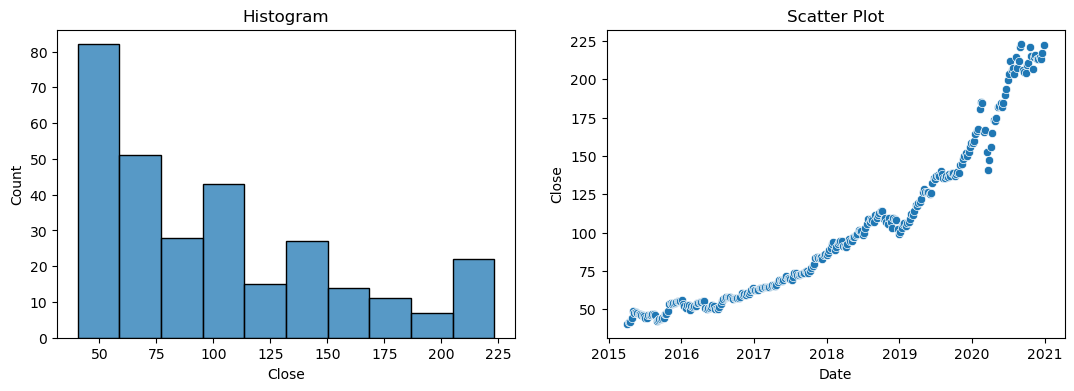


 [요약통계량]
       count    mean    std   min    25%    50%     75%    max
Close  300.0  101.73  51.32  40.5  57.51  90.93  136.58  223.2


In [84]:
# 일반적 EDA
from matplotlib import pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes[0].set_title("Histogram")
sns.histplot(x='Close', data=down_head, ax=axes[0])
axes[1].set_title("Scatter Plot")
sns.scatterplot(x='Date', y='Close', data=down_head, ax=axes[1])
plt.show()

# 요약 통계량
print("\n [요약통계량]")
print(down_head.describe().round(2).T)

ADF Statistics: 2.240, p-value: 0.999
KPSS Statistics: 2.593, p-value: 0.010


C:\Users\sunwa\AppData\Local\Temp\ipykernel_7796\1063936809.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(down_head, regression='c', nlags='auto')


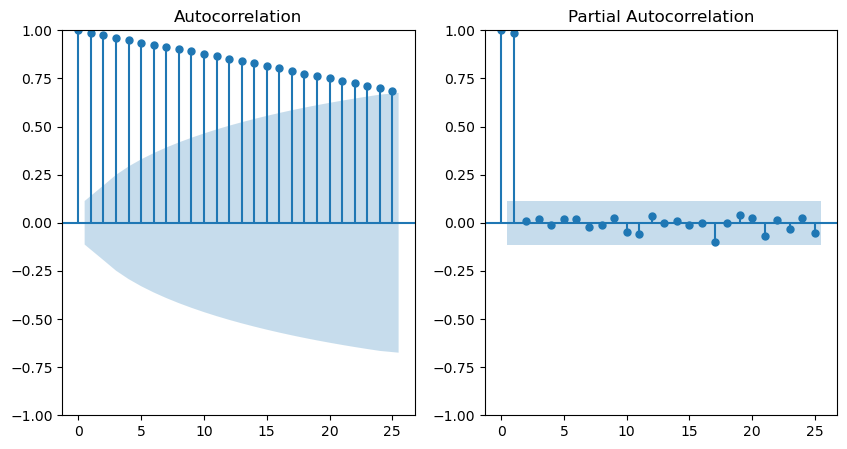

In [85]:
# 시계열에 특화된 EDA
from statsmodels.tsa.stattools import adfuller, kpss
result = adfuller(down_head, regression='c', autolag='AIC')
print("ADF Statistics: {:.3f}, p-value: {:.3f}".format(result[0], result[1]))

result = kpss(down_head, regression='c', nlags='auto')
print("KPSS Statistics: {:.3f}, p-value: {:.3f}".format(result[0], result[1]))
# ADF, KPSS 검정을 통해 시계열이 비정상임을 알 수 있다.

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2, figsize=(10,5))
plot_acf(down_head, ax=ax[0])
plot_pacf(down_head, ax=ax[1])
plt.show()
# ACF 그래프를 통해 시계열이 비정상임을 알 수 있으며, 자기 상관이 있는 것을 알 수 있다.

In [86]:
from statsmodels.stats.diagnostic import acorr_ljungbox
result = acorr_ljungbox(down_head, return_df=True, auto_lag=True).head(3)
print(result)

from statsmodels.stats.stattools import durbin_watson
result = durbin_watson(down_head)
print(result)
# 융박스 테스트와 더빈왓슨 통계량을 통해 시계열이 자기 상관이 있는 것을 알 수 있다.

      lb_stat      lb_pvalue
1  294.753777   4.579097e-66
2  582.583051  3.116721e-127
3  863.943057  5.859132e-187
[0.00083511]


#### 연습문제 #3

In [87]:
# 적절한 차수 모색을 위해 auto_arima를 사용하였다.
from pmdarima import auto_arima
auto_arima(down_head, start_p=1, start_q=1, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5, m=7, seasonal=True, trace=False, error_action='warn', suppress_warnings=True)

ARIMA(order=(3, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True)

In [88]:
from statsmodels.tsa.arima.model import ARIMA
p, d, q = 3, 1, 2
P, D, Q, m = 1, 0, 1, 7
model = ARIMA(down_head, order=(p, d, q), seasonal_order=(P, D, Q, m))
fitted = model.fit()
print(fitted.summary())

C:\Users\sunwa\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sunwa\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  300
Model:             ARIMA(3, 1, 2)x(1, 0, [1], 7)   Log Likelihood                -770.535
Date:                           Fri, 18 Apr 2025   AIC                           1557.070
Time:                                   17:37:03   BIC                           1586.674
Sample:                               04-05-2015   HQIC                          1568.919
                                    - 12-27-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1274      0.091      1.395      0.163      -0.052       0.306
ar.L2          0.9902      0.054     18.216

C:\Users\sunwa\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 연습문제 #4

3.5


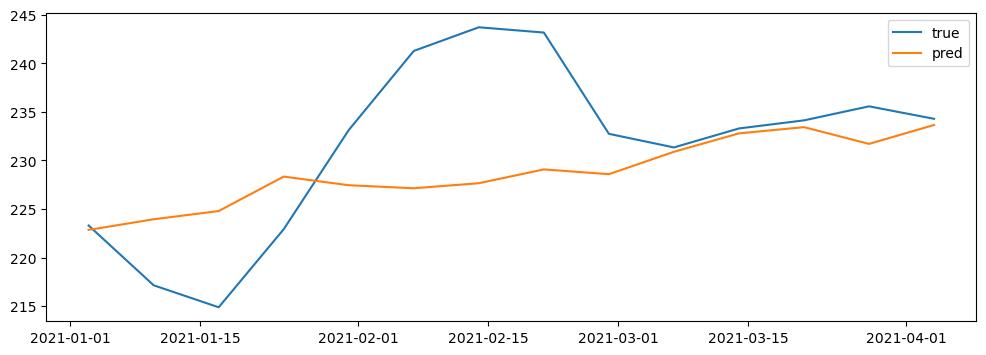

In [89]:
def MAPE(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    return mape

pred = fitted.predict(start=down_tail.index[0], end=down_tail.index[-1])
print(MAPE(down_tail.values, pred.values).round(2))
# 해당 모델로 down_tail 데이터의 기간을 예측한 결과, MAPE 3.5%를 얻었다. 이는 실제값과 예측값이 평균적으로 3.5% 차이난다는 의미이다.

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(down_tail, label='true')
ax.plot(pred, label='pred')
plt.legend()
plt.show()